In [ ]:
# 获取关键词

In [6]:
# 第1步
import pandas as pd

# 读取CSV文件
file_path = '/data1/dxw_data/llm/redbook_final/data/red_01/merged_good_raw.csv'
df = pd.read_csv(file_path)

# 获取post_tag列
post_tags = df['post_tag']

# 初始化一个空集合，用于存储所有标签
all_tags = set()

# 遍历post_tag列，将标签分割并加入集合
for tags in post_tags:
    if isinstance(tags, str):
        tags_list = tags.split()
        all_tags.update(tags_list)

# 将集合转换为列表，并按字典序排序
sorted_tags = sorted(all_tags)

# 保存到txt文件
output_file = '/data1/dxw_data/llm/redbook_final/data/red_01/tags.txt'
with open(output_file, 'w', encoding='utf-8') as f:
    for tag in sorted_tags:
        f.write(f"{tag}\n")

print(f"Tags have been successfully saved to {output_file}.")


Tags have been successfully saved to /data1/dxw_data/llm/redbook_final/data/red_01/tags.txt.


In [14]:
# 第2步
import pandas as pd

# 读取CSV文件
file_path = '/data1/dxw_data/llm/redbook_final/data/red_01/merged_good_raw.csv'
df = pd.read_csv(file_path)

# 定义关键词列表
key_words = [
    "裙", "裙子", "项链", "配饰", "裤", "吊带", "风格", "饰品", "单品", "衬衫", "身材", "耳环", "主义", "混搭", 
    "手链", "元素", "绒", "肩", "鞋子", "瘦", "套装", "款", "毛", "吊坠", "造型", "型", "饰", "袜", 
    "马甲", "系", "夹克", "裳", "推荐", "服", "衣服", "靴", "款", "白t", "搭配", "恤", "大衣", "头", "风", 
    "毛衣", "服", "内搭", "靴子", "链", "套装", "头发", "背心", "毛衣", "外套", "帽", "发型", "包", "衣", 
    "戒指", "鞋", "衫", "袍", "手镯", "单品", "装", "镜", "帽子", "袖"
]

# 定义要处理的列
columns_to_process = ['post_content', 'post_tag', 'post_comments']

# 初始化结果列表
results = []

# 遍历每一行
for _, row in df.iterrows():
    categories = set()  # 用集合来去重
    for column in columns_to_process:
        content = str(row[column])
        for word in key_words:
            index = content.find(word)
            if index != -1:
                start_index = max(0, index - 4)
                snippet = content[start_index:index]
                # 截停在遇到逗号或井号时
                if ',' in snippet:
                    snippet = snippet.split(',')[-1]
                if '#' in snippet:
                    snippet = snippet.split('#')[-1]
                match_snippet = snippet + content[index:index+len(word)]
                categories.add(match_snippet)
    
    # 仅当categories非空时才保存该行
    if categories:
        results.append({
            'poster_id': row['poster_id'],
            'post_id': row['post_id'],
            'categories': ', '.join(categories)
        })

# 转换结果为DataFrame
output_df = pd.DataFrame(results)

# 保存到新的CSV文件
output_file_path = '/data1/dxw_data/llm/redbook_final/data/red_01/matched_categories.csv'
output_df.to_csv(output_file_path, index=False, encoding='utf-8')

print(f"Results have been successfully saved to {output_file_path}.")


Results have been successfully saved to /data1/dxw_data/llm/redbook_final/data/red_01/matched_categories.csv.


In [15]:
# 第3步
import pandas as pd
from collections import Counter

# 读取CSV文件
file_path = '/data1/dxw_data/llm/redbook_final/data/red_01/matched_categories.csv'
df = pd.read_csv(file_path)

# 初始化Counter对象
word_counter = Counter()

# 处理categories列
for categories in df['categories']:
    # 分割字符串，去除多余的空格
    words = [word.strip() for word in categories.split(',')]
    # 更新计数器
    word_counter.update(words)

# 按照出现次数从高到低排序
sorted_words = word_counter.most_common()

# 输出到txt文件
output_file = '/data1/dxw_data/llm/redbook_final/data/red_01/word_frequencies.txt'
with open(output_file, 'w', encoding='utf-8') as f:
    for word, count in sorted_words:
        f.write(f"{word}: {count}\n")

print(f"Word frequencies have been successfully saved to {output_file}.")


Word frequencies have been successfully saved to /data1/dxw_data/llm/redbook_final/data/red_01/word_frequencies.txt.


In [ ]:
# 开始聚类了，下面两步是文本聚类

In [12]:
# 第1步
import json
import numpy as np
from sklearn.cluster import DBSCAN
from sentence_transformers import SentenceTransformer
from tqdm import tqdm
import torch

# Ensure the device is set to GPU
device = torch.device('cuda:5' if torch.cuda.is_available() else 'cpu')

# Read word frequencies from file
word_frequencies_file = '/data1/dxw_data/llm/redbook_final/data/red_01/word_frequencies.txt'
elements = []
frequencies = []

with open(word_frequencies_file, 'r', encoding='utf-8') as f:
    for line in f:
        parts = line.strip().rsplit(': ', 1)
        if len(parts) == 2:
            element, frequency = parts
            elements.append(element)
            frequencies.append(int(frequency))

# Load model and move it to GPU
model = SentenceTransformer('/data1/dxw_data/llm/paraphrase-multilingual-MiniLM-L12-v2', device=device)
embeddings = model.encode(elements, convert_to_tensor=True, device=device)

# Move embeddings back to CPU for clustering
embeddings = embeddings.cpu().numpy()

# Use frequencies as weights for DBSCAN clustering
weights = np.array(frequencies)
eps = 1.0  # Increase the maximum distance between two samples for one to be considered as in the neighborhood of the other
min_samples = 40  # Decrease the number of samples in a neighborhood for a point to be considered as a core point

# Fit DBSCAN clustering
print("Fitting DBSCAN clustering...")
db = DBSCAN(eps=eps, min_samples=min_samples).fit(embeddings, sample_weight=weights)

# Construct clustering result
clusters = {}
labels = db.labels_
unique_labels = set(labels)

for label in unique_labels:
    if label != -1:  # Exclude noise points
        clusters[int(label)] = []

# Display result processing progress
print("Processing cluster results...")
for idx, label in tqdm(enumerate(labels), total=len(labels)):
    if label != -1:  # Exclude noise points
        clusters[int(label)].append(elements[idx])

# Output result to JSON file
output_file = '/data1/dxw_data/llm/redbook_final/data/red_01/clusters_adaptive.json'
with open(output_file, 'w', encoding='utf-8') as f:
    json.dump(clusters, f, ensure_ascii=False, indent=2)

print(f"Clustering results have been successfully saved to {output_file}.")




Fitting DBSCAN clustering...
Processing cluster results...


100%|██████████| 16464/16464 [00:00<00:00, 2411812.69it/s]

Clustering results have been successfully saved to /data1/dxw_data/llm/redbook_final/data/red_01/clusters_adaptive.json.


In [3]:
# 第2步
import pandas as pd
import json
from tqdm import tqdm

# 读取clusters.json文件
clusters_file = '/data1/dxw_data/llm/redbook_final/data/red_01/clusters_adaptive.json'
with open(clusters_file, 'r', encoding='utf-8') as f:
    clusters = json.load(f)

# 创建关键词到类别的映射
keyword_to_cluster = {}
for cluster_id, keywords in clusters.items():
    for keyword in keywords:
        keyword_to_cluster[keyword.strip()] = cluster_id

# 读取matched_categories.csv文件
matched_categories_file = '/data1/dxw_data/llm/redbook_final/data/red_01/matched_categories.csv'
df = pd.read_csv(matched_categories_file)

# 初始化num_category列
df['num_category_text'] = ''

# 处理每一行
for idx, row in tqdm(df.iterrows(), total=len(df)):
    categories = row['categories']
    matched_clusters = set()
    for category in categories.split(','):
        category = category.strip()
        if category in keyword_to_cluster:
            matched_clusters.add(keyword_to_cluster[category])
    df.at[idx, 'num_category_text'] = ', '.join(matched_clusters)

# 保存更新后的CSV文件
output_file = '/data1/dxw_data/llm/redbook_final/data/red_01/matched_categories_with_clusters_adaptive.csv'
df.to_csv(output_file, index=False, encoding='utf-8')

print(f"Updated CSV file has been successfully saved to {output_file}.")


100%|██████████| 8638/8638 [00:00<00:00, 14370.78it/s]

Updated CSV file has been successfully saved to /data1/dxw_data/llm/redbook_final/data/red_01/matched_categories_with_clusters_adaptive.csv.


In [ ]:
# 图片聚类

# 在这里之前，先要去imagebind文件夹，运行imagebind聚类算法。
# /data1/dxw_data/llm/ImageBind/0cluster.ipynb

In [4]:
# 第1步，格式转化
import json
import pandas as pd

# 读取labels.json文件
labels_file = '/data1/dxw_data/llm/redbook_final/data/output_cluster_imagebind_adaptive/labels.json'
with open(labels_file, 'r', encoding='utf-8') as f:
    labels_data = json.load(f)

# 初始化结果列表
results = []

# 处理每个标签
for image_name, category in labels_data.items():
    parts = image_name.split('_')
    poster_id = parts[1]
    post_id = parts[2]
    results.append({
        'poster_id': poster_id,
        'post_id': post_id,
        'nums_category_img': category
    })

# 转换结果为DataFrame
df = pd.DataFrame(results)

# 保存到新的CSV文件
output_file = '/data1/dxw_data/llm/redbook_final/data/clustered_labels_adaptive.csv'
df.to_csv(output_file, index=False, encoding='utf-8')

print(f"Data has been successfully saved to {output_file}.")


Data has been successfully saved to /data1/dxw_data/llm/redbook_final/data/clustered_labels_adaptive.csv.


In [ ]:
# 图片和文本的合并。

In [7]:
# 第1步，具体合并
import pandas as pd

# 读取matched_categories_with_clusters.csv文件
matched_categories_file = '/data1/dxw_data/llm/redbook_final/data/red_01/matched_categories_with_clusters_adaptive.csv'
matched_df = pd.read_csv(matched_categories_file)

# 读取clustered_poster_post_ids.csv文件
clustered_poster_post_ids_file = '/data1/dxw_data/llm/redbook_final/data/clustered_labels_adaptive.csv'
clustered_df = pd.read_csv(clustered_poster_post_ids_file)

# 合并两个数据框
merged_df = pd.merge(clustered_df, matched_df, on=['poster_id', 'post_id'], how='left')

# 保存结果到新的CSV文件
output_file = '/data1/dxw_data/llm/redbook_final/data/combined_clustered_matched_image_text_adaptive.csv'
merged_df.to_csv(output_file, index=False, encoding='utf-8')

print(f"Data has been successfully saved to {output_file}.")


Data has been successfully saved to /data1/dxw_data/llm/redbook_final/data/combined_clustered_matched_image_text_adaptive.csv.


In [4]:
# 第2步：统计指标和参数
import pandas as pd

# 读取combined_clustered_matched_image_text2.csv文件
combined_file = '/data1/dxw_data/llm/redbook_final/data/combined_clustered_matched_image_text_adaptive.csv'
df = pd.read_csv(combined_file)

# 处理num_category_text列，将其展开成独立的数字类别
df['num_category_text'] = df['num_category_text'].fillna('')
df['num_category_text'] = df['num_category_text'].apply(lambda x: x.split(', ') if x else [])

# 初始化一个字典，用于存储每个nums_category_img对应的num_category_text的计数
category_counts = {}

# 遍历每一行，统计num_category_text的计数
for idx, row in df.iterrows():
    nums_category_img = row['nums_category_img']
    num_category_texts = row['num_category_text']
    
    if nums_category_img not in category_counts:
        category_counts[nums_category_img] = {}
    
    for category_text in num_category_texts:
        if category_text not in category_counts[nums_category_img]:
            category_counts[nums_category_img][category_text] = 0
        category_counts[nums_category_img][category_text] += 1

# 计算每个nums_category_img中，num_category_text的占据比例
category_ratios = {}
for nums_category_img, counts in category_counts.items():
    total_count = sum(counts.values())
    category_ratios[nums_category_img] = {k: v / total_count for k, v in counts.items()}

# 转换结果为DataFrame
ratios_list = []
for nums_category_img, ratios in category_ratios.items():
    for num_category_text, ratio in ratios.items():
        ratios_list.append({
            'nums_category_img': nums_category_img,
            'num_category_text': num_category_text,
            'ratio': ratio
        })

ratios_df = pd.DataFrame(ratios_list)

# 保存结果到新的CSV文件
output_file = '/data1/dxw_data/llm/redbook_final/data/category_ratios_adaptive.csv'
ratios_df.to_csv(output_file, index=False, encoding='utf-8')

print(f"Category ratios have been successfully saved to {output_file}.")


Category ratios have been successfully saved to /data1/dxw_data/llm/redbook_final/data/category_ratios_adaptive.csv.


num_category_text        0    1         2         3         4         5    6   \
nums_category_img                                                               
0                  0.000000  0.0  0.000000  0.195402  0.000000  0.000000  0.0   
1                  0.000000  0.0  0.000000  0.000000  0.124088  0.000000  0.0   
2                  0.113636  0.0  0.000000  0.000000  0.000000  0.215909  0.0   
3                  0.000000  0.0  0.196319  0.000000  0.000000  0.000000  0.0   
4                  0.164623  0.0  0.000000  0.000000  0.000000  0.000000  0.0   
...                     ...  ...       ...       ...       ...       ...  ...   
195                0.000000  0.0  0.000000  0.000000  0.000000  0.000000  0.0   
196                0.000000  0.0  0.090226  0.000000  0.000000  0.000000  0.0   
197                0.000000  0.0  0.000000  0.000000  0.000000  0.000000  0.0   
198                0.000000  0.0  0.126761  0.000000  0.000000  0.000000  0.0   
199                0.000000 

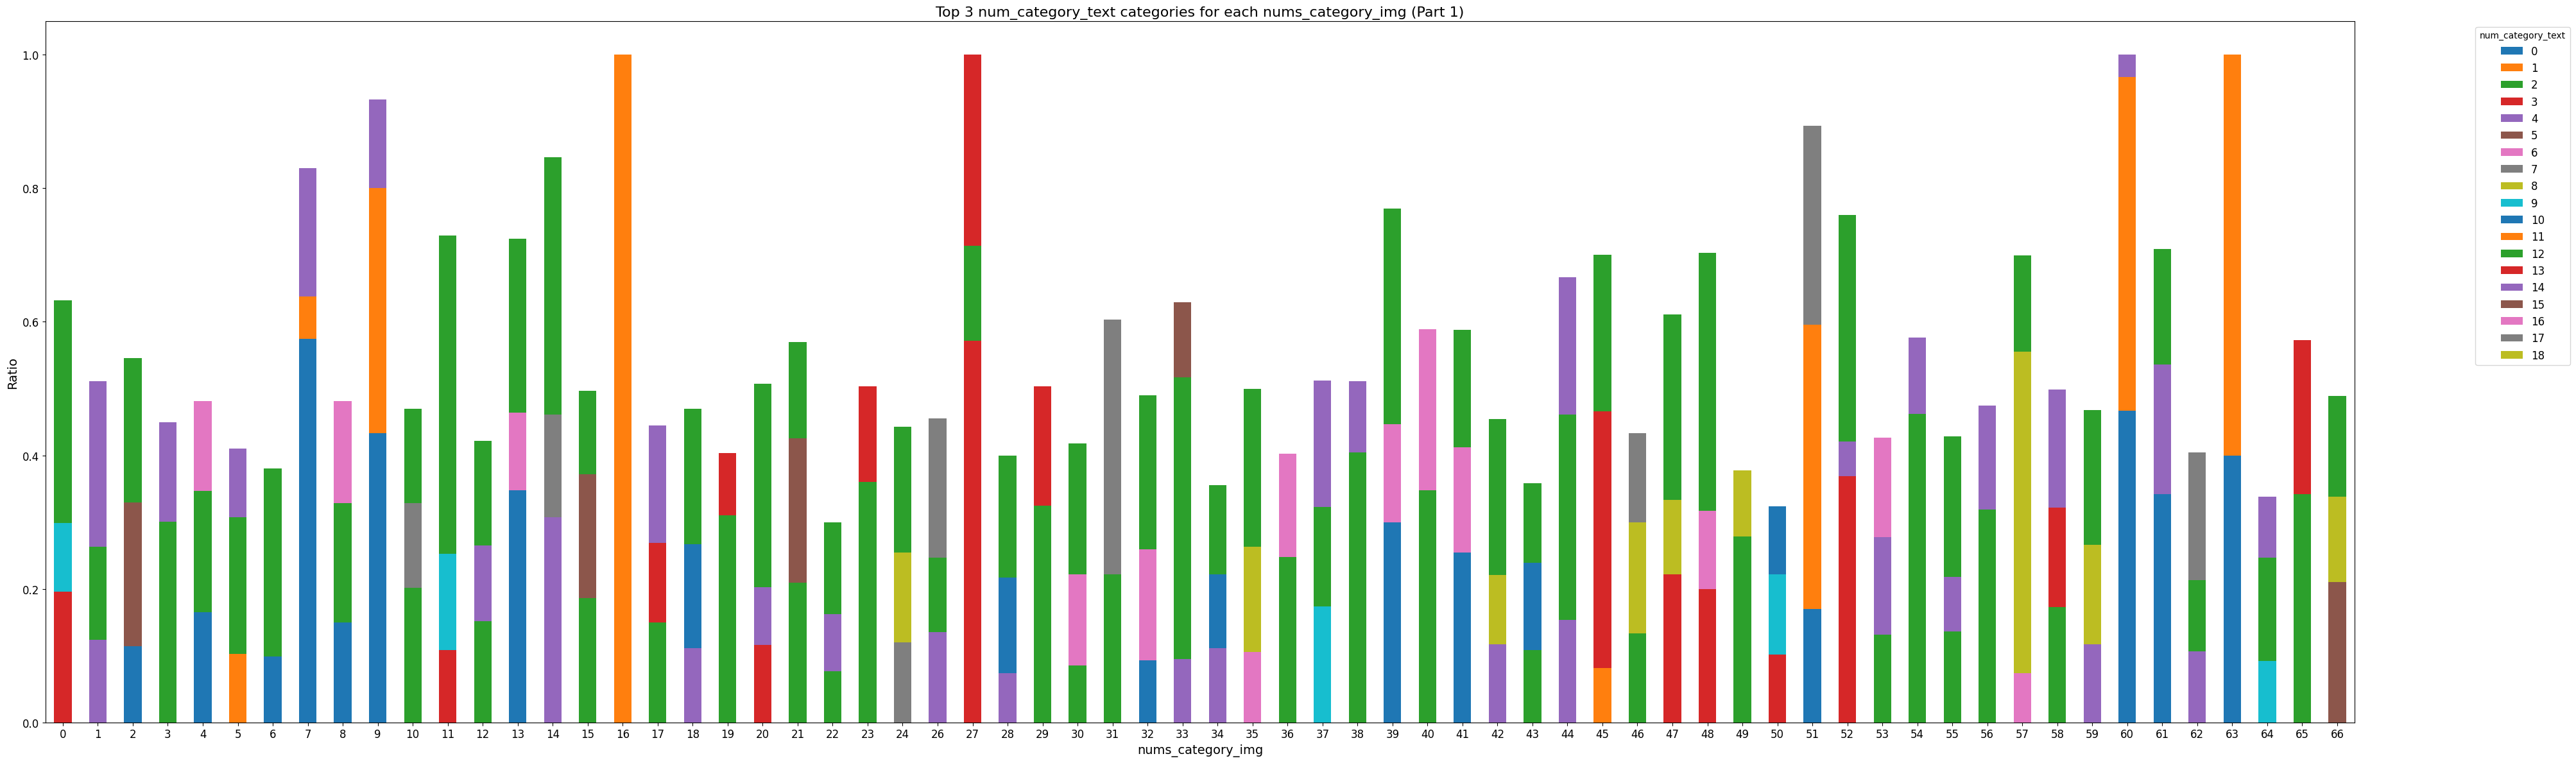

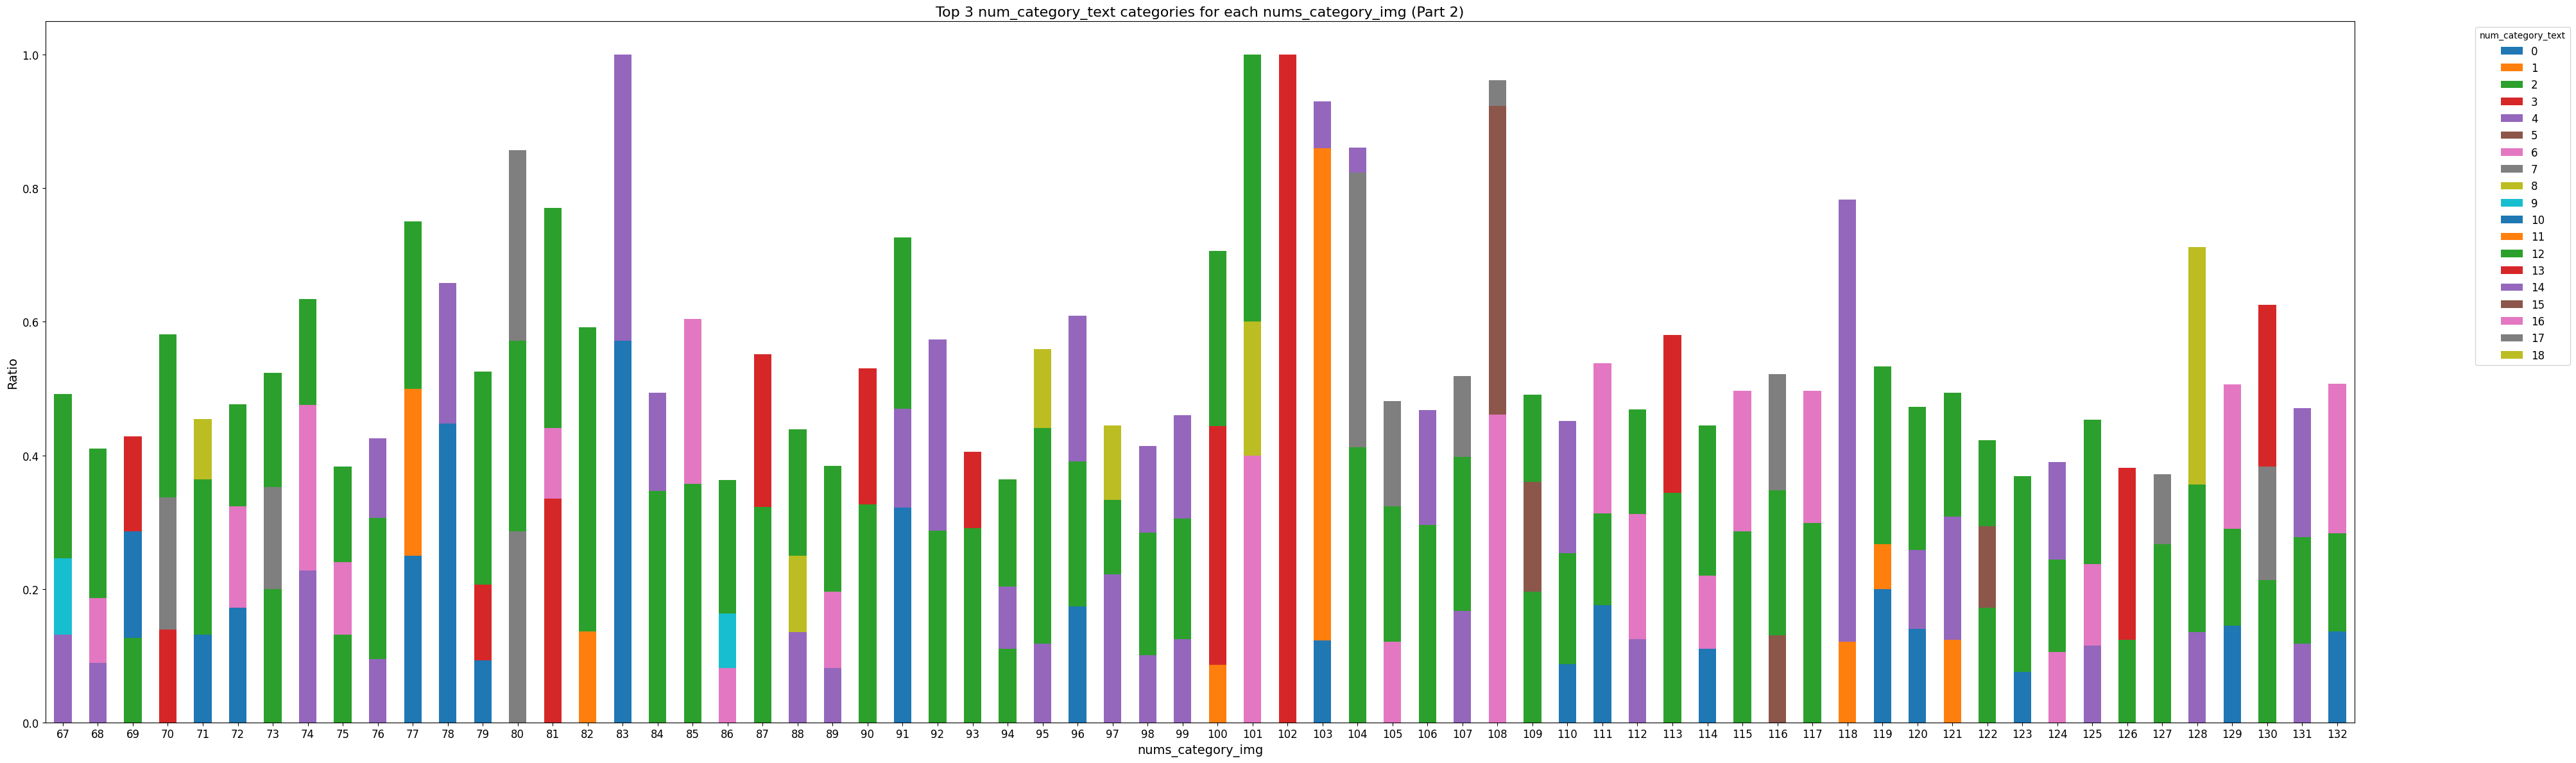

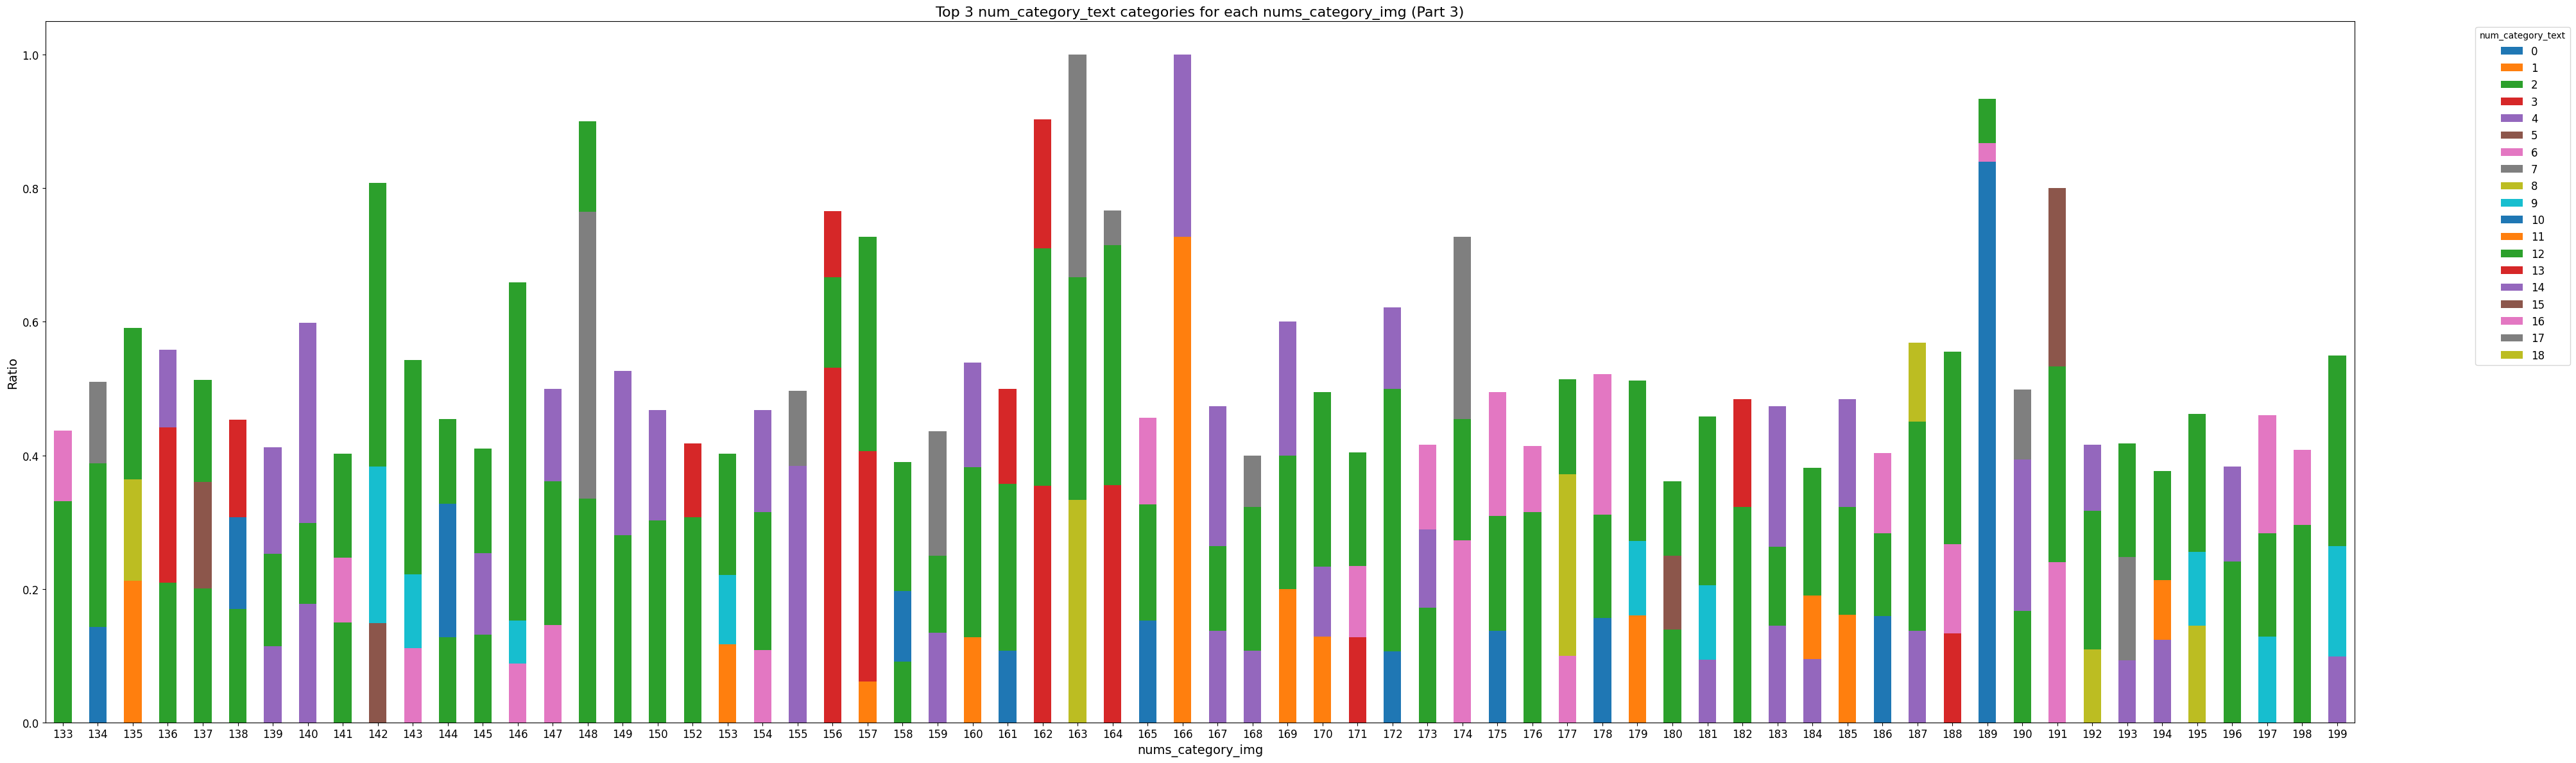

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV file
file_path = '/data1/dxw_data/llm/MKT_data_mining/Multimodal/embedding/label/output_all/category_ratios.csv'
data = pd.read_csv(file_path)

# Function to get the top 3 num_category_text for each nums_category_img
def get_top3_categories(group):
    return group.nlargest(3, 'ratio')

# Group by 'nums_category_img' and apply the function
top3_categories = data.groupby('nums_category_img').apply(get_top3_categories).reset_index(drop=True)

# Create a pivot table for better readability
pivot_table = top3_categories.pivot(index='nums_category_img', columns='num_category_text', values='ratio')

# Fill NaN values with 0 (if needed)
pivot_table = pivot_table.fillna(0)

# Display the table result
print(pivot_table)

# Save the table result to a CSV file
output_table_file_path = '/data1/dxw_data/llm/MKT_data_mining/Multimodal/embedding/label/output_all/top3_categories_table.csv'
pivot_table.to_csv(output_table_file_path)

# Split the data into three parts for plotting
num_categories = len(pivot_table)
split_points = [num_categories // 3, 2 * num_categories // 3]

# Plotting function to avoid repetition
def plot_part(pivot_table_part, part_num):
    fig, ax = plt.subplots(figsize=(40, 12))  # Increase the width to 40
    pivot_table_part.plot(kind='bar', stacked=True, ax=ax)
    ax.set_xlabel('nums_category_img', fontsize=14)
    ax.set_ylabel('Ratio', fontsize=14)
    ax.set_title(f'Top 3 num_category_text categories for each nums_category_img (Part {part_num})', fontsize=16)
    ax.legend(title='num_category_text', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
    ax.tick_params(axis='x', labelsize=12, rotation=0)  # Set x-axis labels to be upright and larger
    ax.tick_params(axis='y', labelsize=12)  # Set y-axis labels larger
    plt.tight_layout()

    # Save the bar chart as a PNG file
    output_chart_file_path = f'/data1/dxw_data/llm/MKT_data_mining/Multimodal/embedding/label/output_all/top3_categories_chart_part{part_num}.png'
    plt.savefig(output_chart_file_path)
    plt.show()

# First part
plot_part(pivot_table.iloc[:split_points[0]], 1)

# Second part
plot_part(pivot_table.iloc[split_points[0]:split_points[1]], 2)

# Third part
plot_part(pivot_table.iloc[split_points[1]:], 3)
